In [86]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [87]:
# mu = 3.986e14
mu = 1.0

# Analytical
def function(p_vec):
    p_norm = np.linalg.norm(p_vec)
    return -mu * p_vec / p_norm**3

def first_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (np.eye(n) / p_norm**3 - 3 * np.outer(p_vec, p_vec) / p_norm**5)

def second_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (-3 / p_norm**5 * (np.outer(np.eye(n), p_vec) + np.kron(np.eye(n), p_vec) + np.kron(p_vec, np.eye(n))) + 15 / p_norm**7 * np.kron(p_vec, np.outer(p_vec, p_vec))) 

In [88]:
# Symbolic
p1, p2, p3 = sp.symbols('p1 p2 p3')
p_vec = sp.Matrix([p1, p2, p3])
p_norm = sp.sqrt(p1**2 + p2**2 + p3**2)
fun = -mu * p_vec / p_norm**3
first_order_der = sp.derive_by_array(fun, (p1, p2, p3))
first_order_der_fun = sp.lambdify((p1, p2, p3), sp.ImmutableDenseNDimArray(first_order_der).tolist(), 'numpy')
second_order_der = sp.derive_by_array(first_order_der, (p1, p2, p3))
second_order_der_fun = sp.lambdify((p1, p2, p3), sp.ImmutableDenseNDimArray(second_order_der).tolist(), 'numpy')

# Example point
std = 1e-1
sample_p_vec = np.random.multivariate_normal(mean=[0, 0, 0], cov=std*np.eye(3)).reshape((3, 1))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_p_vec)).reshape((3, 3))
first_order_partial_derivatives_analytical = first_order_partial_derivatives(sample_p_vec)
print(first_order_partial_derivatives_symbolic)
print(first_order_partial_derivatives_analytical)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_p_vec)).reshape((3*3, 3))
second_order_partial_derivatives_analytical = second_order_partial_derivatives(sample_p_vec)
print(second_order_partial_derivatives_symbolic.shape)
print(second_order_partial_derivatives_analytical.shape)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_p_vec = np.random.multivariate_normal(mean=[0, 0, 0], cov=std*np.eye(3)).reshape((3, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_p_vec)).reshape((3, 3))
    first_order_partial_derivatives_analytical = first_order_partial_derivatives(sample_p_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_p_vec)).reshape((3*3, 3))
    second_order_partial_derivatives_analytical = second_order_partial_derivatives(sample_p_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

[[-9.95296525  0.76616436  1.15025796]
 [ 0.76616436 -0.80134668 13.8351417 ]
 [ 1.15025796 13.8351417  10.75431192]]
[[-9.95296525  0.76616436  1.15025796]
 [ 0.76616436 -0.80134668 13.8351417 ]
 [ 1.15025796 13.8351417  10.75431192]]
True
(9, 3)
(9, 3)
True
All Cases Passed?: True


In [89]:
def differential_equation(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    return np.concatenate((v_vec, function(p_vec)))

def first_order_partial_derivatives_for_the_differential_equation(x_vec):
    first_order_pder = np.zeros((6, 6))
    p_vec = x_vec[:3]
    first_order_pder[:3, 3:] = np.eye(3)
    first_order_pder[3:, :3] = first_order_partial_derivatives(p_vec)
    return first_order_pder

def second_order_partial_derivatives_for_the_differential_equation(x_vec):
    second_order_pder = np.zeros((6 * 6, 6))
    p_vec = x_vec[:3]
    aux = second_order_partial_derivatives(p_vec)
    for i in range(3):
        second_order_pder[6*i+3:6*i+6, :3] = aux[i*3:i*3+3, :]
    return second_order_pder

def f(dt, x_old):
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)
    k4 = differential_equation(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    Dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    Dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = second_order_partial_derivatives_for_the_differential_equation(x_old)
    Hk2 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(np.eye(6), first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1)) @ (dt / 2 * Hk1)
    Hk3 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(np.eye(6), first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2)) @ (dt / 2 * Hk2)
    Hk4 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(np.eye(6), first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

In [90]:
std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

dt = 60.0
f(dt, sample_x_vec), Df(dt, sample_x_vec), Hf(dt, sample_x_vec)

(array([[-8.76153755e-01],
        [ 5.95053509e+01],
        [ 1.23345385e+02],
        [ 1.18727934e-02],
        [ 1.00729403e+00],
        [ 2.07758873e+00]]),
 array([[-2.19116948e+00,  4.82212351e+01,  7.58852154e+01,
          6.04153503e+01,  1.41351181e-02, -2.29843449e-01],
        [ 4.82273072e+01, -2.54404287e+01,  5.97885341e+01,
          1.41351181e-02,  5.97504076e+01, -1.77752964e-03],
        [ 7.58977673e+01,  5.97908934e+01,  3.06759387e+01,
         -2.29843449e-01, -1.77752964e-03,  5.98342421e+01],
        [-5.27244839e-02,  8.03725366e-01,  1.26464280e+00,
          1.01569459e+00,  4.93731013e-04, -8.75631742e-03],
        [ 8.03927728e-01, -4.40623926e-01,  9.96578791e-01,
          4.92432822e-04,  9.90592147e-01, -6.71853922e-05],
        [ 1.26506111e+00,  9.96657419e-01,  4.94829171e-01,
         -8.75900095e-03, -6.76898061e-05,  9.93795484e-01]]),
 array([[-7.32244873e+01,  2.37693346e+01,  3.74087187e+01,
          2.46825747e-02,  1.13221998e-03, -2.03

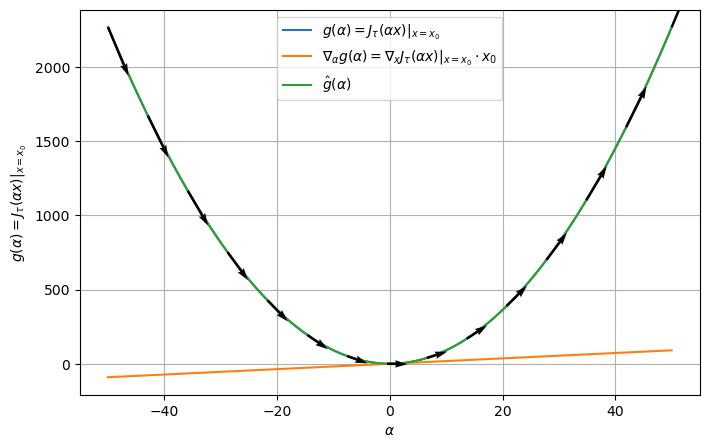

In [252]:
def cost_function(x_vec):
    x_norm = np.linalg.norm(x_vec)
    return x_norm

def cost_function_grad(x_vec):
    x_norm = np.linalg.norm(x_vec)
    return x_vec / x_norm

def cost_function_hessian(x_vec):
    x_norm = np.linalg.norm(x_vec)
    return np.eye(len(x_vec)) / x_norm - np.outer(x_vec, x_vec) / x_norm**3

def test_function(alpha, x_vec):
    cost = cost_function(alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(alpha, x_vec):
    cost = cost_function(alpha * x_vec)
    jacobian = cost_function_grad(alpha * x_vec)
    return cost * jacobian.T @ x_vec

def test_function_hessian(alpha, x_vec):
    cost = cost_function(alpha * x_vec)
    jacobian = cost_function_grad(alpha * x_vec)
    hessian = cost_function_hessian(alpha * x_vec)
    return cost * x_vec.T @ hessian @ x_vec + x_vec.T @ (jacobian @ jacobian.T) @ x_vec

def test_function_approx(alpha, x_vec, point=0):
    return test_function(point, x_vec) + (alpha - point) * test_function_grad(point, x_vec) + (alpha - point)**2 / 2 * test_function_hessian(point, x_vec)

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

alpha_bounds = np.linspace(-5e1, 5e1, 100)
cost_values = np.array([test_function(alpha, sample_x_vec) for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function = np.array([test_function_approx(alpha, sample_x_vec, point=np.random.rand()).flatten() for alpha in alpha_bounds])

# Plot function and gradient
plt.figure(figsize=(8, 5))
plt.plot(alpha_bounds, cost_values, label=r'$g(\alpha) = J_\tau(\alpha x)|_{x = x_0}$')
plt.plot(alpha_bounds, gradient_values, label=r'$\nabla_\alpha g(\alpha) = \nabla_x J_\tau(\alpha x)|_{x = x_0} \cdot x_0$')
plt.plot(alpha_bounds, taylor_series_second_order_expansion_cost_function, label=r'$\hat{g}(\alpha)$')

# Gradient arrows
num_arrows = 15
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)
plt.quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], np.ones_like(arrow_indices), gradient_values[arrow_indices], angles='xy', scale_units='xy', color='black', width=0.004, zorder=2)

# Labels and grid
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$g(\alpha) = J_\tau(\alpha x)|_{x = x_0}$')
plt.grid()
plt.legend()
plt.show()

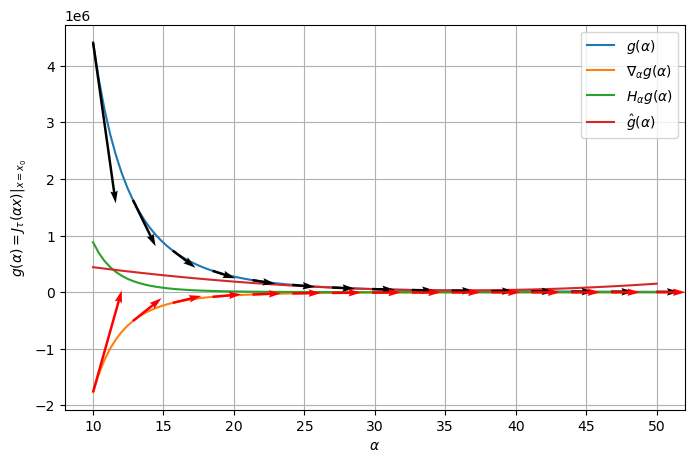

In [371]:
mu = 1e6

def cost_function(p_vec):
    p_norm = np.linalg.norm(p_vec)
    return -mu * p_vec / p_norm**3

def cost_function_grad(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (np.eye(n) / p_norm**3 - 3 * np.outer(p_vec, p_vec) / p_norm**5)

def cost_function_hessian(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (-3 / p_norm**5 * (np.outer(np.eye(n), p_vec) + np.kron(np.eye(n), p_vec) + np.kron(p_vec, np.eye(n))) + 15 / p_norm**7 * np.kron(p_vec, np.outer(p_vec, p_vec))) 

def test_function(alpha, x_vec):
    cost = cost_function(alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(alpha, x_vec):
    cost = cost_function(alpha * x_vec)
    jacobian = cost_function_grad(alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(alpha, x_vec):
    n = len(x_vec)
    cost = cost_function(alpha * x_vec)
    jacobian = cost_function_grad(alpha * x_vec)
    hessian = cost_function_hessian(alpha * x_vec)
    return cost.T @ np.kron(np.eye(n), x_vec).T @ hessian @ x_vec + x_vec.T @ jacobian @ jacobian.T @ x_vec

def test_function_approx(alpha, x_vec, point=0):
    return test_function(point, x_vec) + (alpha - point) * test_function_grad(point, x_vec) + (alpha - point)**2 / 2 * test_function_hessian(point, x_vec)

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

alpha_bounds = np.linspace(1e1, 5e1, 100)
cost_values = np.array([test_function(alpha, sample_x_vec) for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function = np.array([test_function_approx(alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])

# Plot function and gradient
plt.figure(figsize=(8, 5))
plt.plot(alpha_bounds, cost_values, label=r'$g(\alpha)$')
plt.plot(alpha_bounds, gradient_values, label=r'$\nabla_\alpha g(\alpha)$')
plt.plot(alpha_bounds, hessian_values, label=r'$H_\alpha g(\alpha)$')
plt.plot(alpha_bounds, taylor_series_second_order_expansion_cost_function, label=r'$\hat{g}(\alpha)$')

# Gradient arrows
num_arrows = 15
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)
plt.quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], np.ones_like(arrow_indices), gradient_values[arrow_indices], angles='xy', scale_units='xy', color='black', width=0.004, zorder=2)
plt.quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], np.ones_like(arrow_indices), hessian_values[arrow_indices], angles='xy', scale_units='xy', color='red', width=0.004, zorder=2)

# Labels and grid
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$g(\alpha) = J_\tau(\alpha x)|_{x = x_0}$')
plt.grid()
plt.legend()
plt.show()